In [ ]:
# NOTES

Tænker også lix-tallet er lidt for højt i starten tænker idéen er det skal være let, sværere, sværest. Føler det

sætninger som:
"It then employs a variational bayes kalman filter to estimate that choice probability based on the opponent's behavior"

eller

"In this sense, the 0-TOM does not attribute any intentionality or adaptivity to the opponent, but treats the opponent's choices as randomly generated phenomena."

er noget jeg vil tænke er paper forklaringer, frem for en tutorial (som jeg tænker skal hjælpe læseren ikke gøre det sværere)

forbedringer inkluderer
randomly generated phenomena (random biased agent -  meget mere konkret)
+ 
undlade at snakke om hvordan den gør hvad den gør, men nærmere hvad den gør og evt. hvorfor den gør det


rettelser til k-tom:
1) flyt tekst fra code chunks til text chunks
2) du viser ikke hvordan man programmerer ikke i k-tom (or you kinda do, men det måske lidt vildledende - brug et andet ord)
sir_tom analogies er måske også lidt wierd (og ikke så consistent med de andre tutorials)

brug $ $ til matematik notation (e.g. for alle $k = 1$)

jeg tænker og TOM skal ændres til ToM

# Introduction to the computional Theory of Mind (ToM) model

The following is an introduction to the computational implementation of Theory of Mind (ToM) originally presented by [Devaine et al. (2017)](http://dx.plos.org/10.1371/journal.pcbi.1005833), which is the model used by the ToM agents in the tomsup package. The guide will first give a conceptual overview of the model and its parameters, and will then go through the model in detail.

---
## Conceptual overview
The ToM model used here is an attempt at approximating the theory of mind processes in humans. The simplest kind of ToM agent - the 0-ToM - assumes that it's opponent chooses randomly with a specific probability. It then employs a variational bayes kalman filter to estimate that choice probability based on the opponent's behavior, and makes the choice that will give it the most value, given the opponent's choice probability. In this sense, the 0-TOM does not attribute any intentionality or adaptivity to the opponent, but treats the opponent's choices as randomly generated phenomena. Within the context of this module, this would correspond to assuming that the opponent is a random bias agent.

The more advanced 1-ToM, in turn, assumes that its opponent is a 0-ToM trying to predict the actions of the 1-ToM in the manner described above. The 1-TOM takes its opponent's perspective by simulating a 0-ToM model given the same inputs as the opponent. Based on this simulation of its opponent, and on an estimation of the opponent's model parameters, 1-ToM finally estimates the opponent's choice probability, and makes its own choice accordingly. An even more sophisticated 2-TOM agent, then, assumes its opponent to either be a 1-ToM or a 0-ToM. This means that, in order to predict it's opponent's move, 2-TOM must not only estimate the opponent's model parameters, but also estimate which model the opponent is using; that is, whether the opponent is a 0-TOM or a 1-TOM. 2-TOM does this on a turn by turn basis, by comparing the estimated choice probabilities to te opponent's actual behavior.

In general, then, the k-TOM agent with k>0 estimates beliefs and model parameter values for k simulated opponents with levels between 0 and k-1. Based on these belief and parameter estimates it determines a different choice probability for each possible opponent type. It is the average of these choice probabilities, weighted by the estimated probability that the opponent is of the given type, which is used as the final estimate of the opponent's choice probability. Importantly, because k-TOM must simulate an opponent who is also simulating its own opponent, and where this simulated opponent may also have its own simulation and so on, k-TOM agents with higher levels perform many layers of recursive estimation, which means they become computationally demanding.

k-TOM has the following model parameters: its sophistication level k, its volatility $\sigma$, its behavioral temperature $\beta$, its bias b and its dilution d. The sophistication level is described above. The volatility denotes how much k-TOM expects its opponent's parameters to drift, putting a lower bound on the uncertainty of its parameters estimates. The behavioral temperature decides to which degree, given an estimated choice proability for the opponent, k-TOM will randomize its behavior. The bias simply denotes an a priori preference for choosing one option or the other. And the dilution parameter decides to which degree k-TOM reduces its certainties in its estimations of the opponent's sophistication level, which allows it to re-estimate the level of an opponent who switches strategy during the game. 

The sophistication level can be any whole non-negative number, although sophistication levels above 5 are usually too computationally demanding to be practical. The volatility is inputted on a log scale, with lower numbers meaning less assumed volatility of opponent parameters. As default it is set to -2. The behavioral temperature is also inputted on a log scale, with lower numbers meaning less randomized behavior. It is as default set to -1. 
Bias can be any positive or negative number, with negative numbers indicating a preference for option 0, while positive numbers indicate a preference for option 1. dilution can be any number between 0 and 1, where 0 means no forgetting, and 1 means complete resetting of estimated probabilites of opponent levels every turn. Note that while both bias and dilution have no direct effect on k-TOM's behavior if set to 0, it still estimates them for the opponent. If they are set to "None", they will not be estimated for the opponent. As default, bias is set to 0, because it is necessary for k-TOM to predict the behavior of random bias opponents, and dilution is set to "None".

k-TOM uses a variational Bayes Laplace approximation (for more on this, see chapter 5 in [this book](https://bookdown.org/rdpeng/advstatcomp/laplace-approximation.html)) to estimate opponent parameter values. This means that every parameter estimate is represented with a mean and a variance. The estimate of the opponent's choice probability is represented with a mean, produced by simulating the opponent's choice alorithm using the means of the estimated parameters, and a variance, which is a composite of the variances of all parameter estimates. The estimated probability of the opponent having a certain sophistication level is represented with a simple probability.
 In the end of this tutorial, after the practical examples for the k-TOM agent, there is a more thorough explanation of the mathematics behind the k-TOM model. But now we will move the in-code implementation of the k-TOM agent.


# Application and code

In the following, we will show how to program a k-TOM agent, how to set its model parameters, how to make it compete, and how to extract its estimates at a given time.

First we create some different TOM agents. We set their volatilities behavioral temperatures. Notice that if bias or dilution is set to 0, they do not affect the k-TOM's own behavior, but k-TOM still estimates them for its opponent. If they are set to "None", they are also not estimated for the opponent. 

We set all k-TOM agents to save their history, which will later allows us to extract their estimates on any given round.

#

In [ ]:
#T##his is only relevant if tomsup was installed from the github folder
#Move up to the correct folder
import os
os.chdir('..')
#And import the tomsup library
import tomsup as ts

#Get the competitive penny game payoff matrix
penny = ts.PayoffMatrix("penny_competitive")

Error: Jupyter cannot be started. Error attempting to locate jupyter: 'Kernelspec' module not installed in the selected interpreter ({0}).
 Please re-install or update 'jupyter'.

In [35]:
#Create a 0-TOM agent with volatility -2, temperature -1, and no bias or dilution.
sir_TOM0 = ts.TOM(level = 0, volatility= -2,  b_temp= -1, bias = None, dilution = None, save_history = True)

#Create a 1-TOM agent with a higher volatility -2, temperature -1, no bias or dilution, but which estimates the bias of its opponent.
sir_TOM1 = ts.TOM(level = 1, volatility= 1,  b_temp= -1, bias = 0, dilution = None, save_history = True)

#Create a 2-TOM agent with default values: volatility -2, temperature -1, no bias or dilution, but which estimates the bias of its opponent.
sir_TOM2 = ts.TOM(level = 2, volatility= -2,  b_temp= -1, bias = 0, dilution = None, save_history = True)

#Create a 2-TOM agent with volatility -2, a low temperature -4, a bias of 0.5 and a dilution of 0.4.
sir_TOM2_d = ts.TOM(level = 2, volatility= -2,  b_temp= -4, bias = 0.5, dilution = 0.4, save_history = True)

In [36]:
#We can extract the given parameter values of the agents
print(sir_TOM0.get_parameters())
print(sir_TOM2.get_parameters())
print(sir_TOM2_d.get_parameters())

{'volatility': -2, 'b_temp': -1}
{'volatility': -2, 'b_temp': -1, 'bias': 0}
{'volatility': -2, 'b_temp': -4, 'dilution': 0.4, 'bias': 0.5}


In [37]:
#Make the 0-TOM agent compete a number of rounds while saving its history. It automatically updates its beliefs based on the op_choice behavior we input.
sir_TOM0.compete(p_matrix = penny, agent = 0, op_choice=None, save_history = True)
sir_TOM0.compete(p_matrix = penny, agent = 0, op_choice=1, save_history= True)
sir_TOM0.compete(p_matrix = penny, agent = 0, op_choice=1, save_history = True)

1

In [49]:
#We can see 0-TOM's estimates of its opponent as they were on the latest round. The dictionary "own_states" contains 0-TOM's estimates of its opponent. p_op_mean0 is the estimated mean choice probability of the opponent, p_op_var0 is the variance of that estimate, and p_self is 0-TOM's own choice probability. The dictionary "opponent_states" contains the simulated estimates of the opponent; it is empty because there is no recursive belief simulation in the 0-TOM model.

print(sir_TOM0.get_internal_states())

print("---")

#There is also a print function which can give a better overview of the internal states
sir_TOM0.print_internal()

{'opponent_states': {}, 'own_states': {'p_op_mean0': 0.7631368312390914, 'p_op_var0': -0.1979324771056322, 'p_self': 0.8528708712402868}}
---
opponent_states
own_states
|   p_op_mean0:  0.7631368312390914
|   p_op_var0:   -0.1979324771056322
|   p_self:      0.8528708712402868


In [42]:
#We can also get the internal states of 0-TOM on all the trials it has partaken in. They come out as a pandas dataframe, with the agents choice  and internal states for each round
print(sir_TOM0.get_history())

choice                                    internal_states
0       0  {'opponent_states': {}, 'own_states': {'p_op_m...
1       1  {'opponent_states': {}, 'own_states': {'p_op_m...
2       1  {'opponent_states': {}, 'own_states': {'p_op_m...


In [ ]:
#From here, we can extract the desired internal state of 0-TOM, and plot them across trials.None

###PLOT CODE###

In [43]:
#We now make the 1-TOM agent compete in order to look at its internal states
sir_TOM1.compete(p_matrix = penny, agent = 0, op_choice=None, save_history = True)
sir_TOM1.compete(p_matrix = penny, agent = 0, op_choice=1, save_history= True)
sir_TOM1.compete(p_matrix = penny, agent = 0, op_choice=1, save_history = True)

1

In [54]:
#We can print its internal states - which includes 1-TOM's estimates of its opponent, but also its simulated opponents estimates of 1-TOM itself. Inside the "opponent_states" part is found the internal states of the simulated 0-TOM, which have the same structure as the 0-TOM agent from before. In the "own_states" section, we can now see all of 1-TOM's estimates. p_k is the probability of the opponent having a specific level; it is one because 1-TOM only simulates one level. The p_op_mean is the mean estimate of the opponent's choice probability. The param_mean and the param_var hold the means and variances, respectively, of the estimates of each of the opponent's parameters. The order of the numbers is always the estimate of the temoerature, the volatility, the bias and the dilution, excluding those that were set as "None" in the beginning. The gradient is a measure of the size of the influence on variations in the parameter estimates on the simulated opponent's behavior - this is explained more in the last section. And finally, the p_self is 1-TOM's own choice probability.
sir_TOM1.print_internal()

opponent_states
|   0-ToM
|   |   opponent_states
|   |   own_states
|   |   |   p_op_mean0:  0.42373232566770774
|   |   |   p_op_var0:   0.5009137645855161
own_states
|   p_k:         [1.0]
|   p_op_mean:   [0.21071254142074616]
|   param_mean:  [[0.25130848130850025, -0.14251192446213326, 0.5941358930721726]]
|   param_var:   [[1.836017241209727, -0.05626325940758126, -0.3732623811410634]]
|   gradient:    [[-0.2778543939491174, 0.3834041799108401, 0.9999999979576346]]
|   p_self:      0.615593062275007


In [53]:
#Again, we can get the internal states on every trial with the get_history command. This is useful for if the internal states have a use.
print(sir_TOM1.get_history())

choice                                    internal_states
0       0  {'opponent_states': {0: {'opponent_states': {}...
1       1  {'opponent_states': {0: {'opponent_states': {}...
2       1  {'opponent_states': {0: {'opponent_states': {}...


In [ ]:
#And finally, there are pre-made functions for plotting the internal states of the 1-TOM.

###PRINT FUNCTIONS###

In [57]:
#We now make a 2-TOM with all parameters enabled compete, to show how its structure looks
#sir_TOM2_d.compete(p_matrix = penny, agent = 0, op_choice=None, save_history = True)
sir_TOM2_d.compete(p_matrix = penny, agent = 0, op_choice=1, save_history= True)
sir_TOM2_d.compete(p_matrix = penny, agent = 0, op_choice=1, save_history = True)

1

In [61]:
#We print its internal states. The structure here is similar, except that 2-TOM simluates both a 0-TOM, for which the estimated internal states are shown first, and a 1-TOM, which has its own simulated 0-TOM opponent. We also see that in the 2-TOM's own states, there are two sophistication levels p_k. There are also a p_op_mean, and a vector of parameter estimate mean and variances, now with four numbers because all four parameters are included, for each for the two simulated opponent levels. For higher levels these numbers of values and vectors increase accordingly.
sir_TOM2_d.print_internal()

opponent_states
|   0-ToM
|   |   opponent_states
|   |   own_states
|   |   |   p_op_mean0:  1.14512949598081
|   |   |   p_op_var0:   0.4604105421400479
|   1-ToM
|   |   opponent_states
|   |   |   0-ToM
|   |   |   |   opponent_states
|   |   |   |   own_states
|   |   |   |   |   p_op_mean0:  1.8363020308884432
|   |   |   |   |   p_op_var0:   0.558131073865091
|   |   own_states
|   |   |   p_k:         [1.0]
|   |   |   p_op_mean:   [1.5218527366836434]
|   |   |   param_mean:  [[-0.23900047043730568, -0.018513698072400202, 0.0, 0.2657897899344984]]
|   |   |   param_var:   [[1.6018477898573253, -0.2679639003938506, 0.0, -0.6306235471913909]]
|   |   |   gradient:    [[-0.005160032607864906, -1.2560001440364843, 0.0, 0.999999995201506]]
own_states
|   p_k:         [0.5569244021121262, 0.44307559788787376]
|   p_op_mean:   [0.0782635775806334, 0.04396096544609379]
|   param_mean:  [[-0.05962926463117222, 0.21128841564965012, 0.0, 0.7704868372920851], [0.0011933444242790041, 0.396

In [ ]:
#We can of course also for 2-TOMs get the internal states for every round
print(sir_TOM2_d.get_history())

#And it is also possible to plot some core information for them

###PLOT FUNCTION

In [63]:
#Finally, we can of course make a group of TOM agents and have them compete against each other.

#Create list of agents
all_agents = ['RB', '0-TOM', '1-TOM', '2-TOM']
#And set their params. Note that unspecified parameters values simply are set as the default values.
all_params = [{'bias': 0.8}, {'volatility': -2, 'b_temp': -1}, {}, {'dilution': 0.2}]

#We add the save_history to all parameter sets, in order to make sure we can get the internal states of all agents
for d in all_params:
    d['save_history'] = True

#Now we create the group and set the tournament evnironment
group = ts.AgentGroup(all_agents, all_params)
group.set_env(env = 'round_robin')

#Finally, we make the group compete 20 simulations of 30 rounds
results = group.compete(p_matrix = penny, n_rounds = 30, n_sim = 20, save_history = True)


Currently the pair, ('RB', '0-TOM'), is competing for 20 simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation 4 out of 20
	Running simulation 5 out of 20
	Running simulation 6 out of 20
	Running simulation 7 out of 20
	Running simulation 8 out of 20
	Running simulation 9 out of 20
	Running simulation 10 out of 20
	Running simulation 11 out of 20
	Running simulation 12 out of 20
	Running simulation 13 out of 20
	Running simulation 14 out of 20
	Running simulation 15 out of 20
	Running simulation 16 out of 20
	Running simulation 17 out of 20
	Running simulation 18 out of 20
	Running simulation 19 out of 20
	Running simulation 20 out of 20
Currently the pair, ('RB', '1-TOM'), is competing for 20 simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation 4 out of 20
	Running simulation 5 out of 20

In [82]:
#We can now investigate the results dataframe. From here we can also extract the internal states of any agent at any given time.
results.head(5)

#We can get out all rounds between two specific agents
results.loc[results['agent0'].isin(['0-TOM', '1-TOM']) & results['agent1'].isin(['0-TOM', '1-TOM'])]

#And there are also a few premade plot functions to see how the tournament went.

###PLOT FUNCTION

,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1,agent0,agent1
0,0,0,1,0,-1,1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",0-TOM,1-TOM
1,0,1,0,1,-1,1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",0-TOM,1-TOM
2,0,2,1,0,-1,1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",0-TOM,1-TOM
3,0,3,0,0,1,-1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",0-TOM,1-TOM
4,0,4,0,1,-1,1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",0-TOM,1-TOM
...,...,...,...,...,...,...,...,...,...,...
595,19,25,1,0,-1,1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",0-TOM,1-TOM
596,19,26,1,1,1,-1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",0-TOM,1-TOM
597,19,27,0,0,1,-1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",0-TOM,1-TOM
598,19,28,1,0,-1,1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",0-TOM,1-TOM


## Mathematical description: the k-TOM model

Following the conceptual introduction of we will go further into how the mathematical underpinnings of the ToM agent. We will start of with an introduction to 0-ToM and then generalize to the k-ToM agent.

### The 0-ToM
All ToM agents estimate their opponents’ parameter values $\theta$ in order to learn the choice probability of their opponents $P_t^{op}$, but since 0-ToM assumes its opponent to use a RB strategy, the estimation of the probability parameter and the choice probability $P_t^{op}$ becomes identical. The choice probability parameter is estimated as a normal distribution with mean $\mu$ and variance $\Sigma$, each of which are updated on a turn-by turn-basis, based on the opponent’s last choice. This is done using a a variational Bayes Laplace approximation for parameters with a linear relation to observed behaviour. In the graphical model (see following figure 1), 0-ToM’s learning and decision process can be seen. First the variance $\Sigma$ is updated, then the mean estimate $\mu$. This allows the estimation of the opponent’s choice probability $P_t^{op}$, after which the expected payoff difference $\Delta V$ can be calculated and inserted in the softmax function to decide 0-ToM’s own choice probability $P(c^{self} = 1)$.

<img src="img/gm_tom_0.png" alt="Graphical Models of 0-ToM" style="width: 500px;"/>

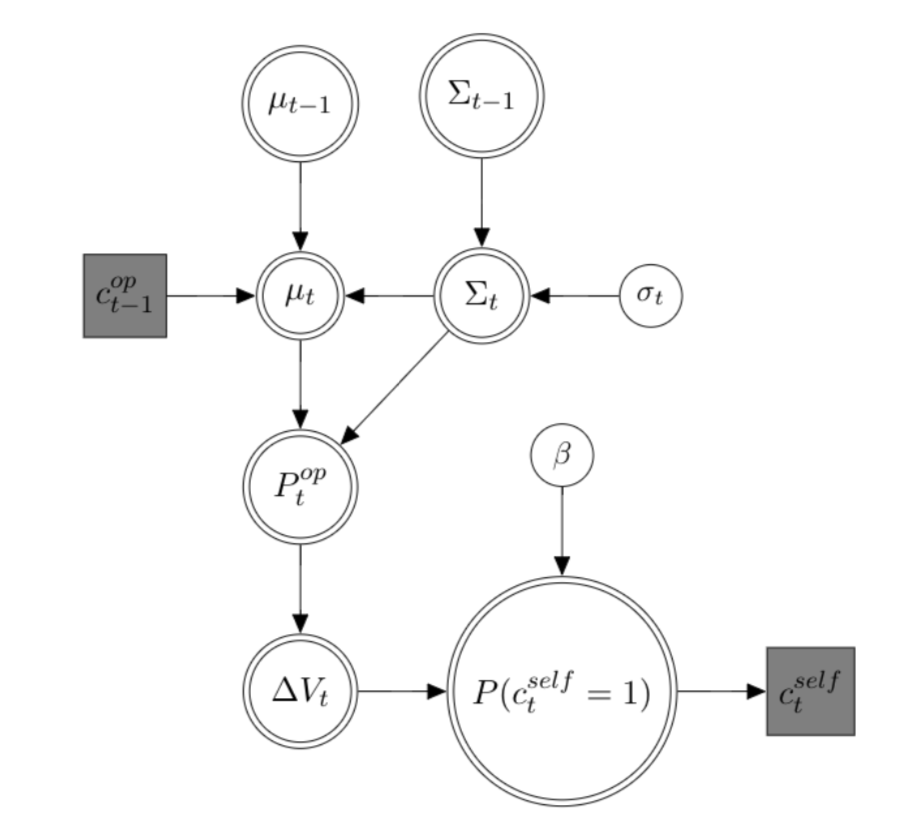

In [2]:
#if if is not read above it should be read using this code:
from IPython.display import Image # for loading in images
Image("img/gm_tom_0.png")

This graphical model is meant to help the reader understand the structure of the agent, however the graphical model is by no mean necessary for understanding the agent so the reader the more mathematically inclined reader should feel free to move straight to the formulas. 

In the graphical model the shaded (grey) constitute observed variables while non-shaded (white) is unobserved. squares and circles constitute discrete and continuous varaibles respectively. The double bordered variables are deterministic. For more on graphical models see Bartlema et al. (2014).

Let us briefly go through the graphical model, starting at the output $c_t^{self}$, which is the choice of the agent at time $t$, which is stocastically determined 

Let start by the parameters which already defined for this agent, volatility $\sigma$ = -2, and the  behavioural temperature $\beta$ = -1.
